In [1]:
import ssn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.ndimage.interpolation
import time

%matplotlib inline

In [64]:
# Save variables for simulations
start_time = time.time()
filename = 'saved_vars/Aug-19-results.p'
pickle.dump([W_EE, W_EI, W_IE, W_II, OP_map, OD_map, SS_E, SS_I, results_E, results_I, sum_field_sizes_E, sum_field_sizes_I, res_E, res_I, crf_results, dom_results, ndom_results, mono_results, crf_nd_results, crf_results_I, dom_results_I, ndom_results_I, mono_results_I, crf_nd_results_I, inner_d_E, inner_d_I], open(filename, 'wb'))
print "Elapsed time to pickle: ", time.time()-start_time

NameError: name 'pickle' is not defined

In [ ]:
# Load variables for simulations
filename = 'saved_vars/Aug-19-results.p'
start_time = time.time()
[W_EE, W_EI, W_IE, W_II, OP_map, OD_map, SS_E, SS_I, results_E, results_I, sum_field_sizes_E, sum_field_sizes_I, res_E, res_I, crf_results, dom_results, ndom_results, mono_results, crf_nd_results, crf_results_I, dom_results_I, ndom_results_I, mono_results_I, crf_nd_results_I, inner_d_E, inner_d_I] = np.load(filename, 'rb')
print "Elapsed time: ", time.time() - start_time

In [411]:
""" An outdated and very slooooow implementation of a gabor function adapted
from matlab. Don't use. """
def gabor3(sig_x, sig_y, theta, k, phi, fsize): 
    gabor = np.zeros((fsize,fsize))
    for i in range(int(fsize)):
        for j in range(int(fsize)):
            x = j - np.floor(fsize/2) 
            y = i - np.floor(fsize/2) 
            Xj = x*np.cos(theta) - y*np.sin(theta);
            Yj = x*np.sin(theta) + y*np.cos(theta);
            gabor[i,j] = (1/(2*np.pi*sig_x*sig_y))*np.exp(-1*Xj**2/(2*sig_x**2) - Yj**2/(2*sig_y**2) )*np.cos(k*Xj-phi);
    return gabor

def gabor2(sig_x, sig_y, theta, k, phi, fsize, sine=False): 
    vals = np.linspace(-np.floor(fsize/2), np.floor(fsize/2), fsize)
    xv,yv= np.meshgrid(vals,vals)
    Xj = xv*np.cos(theta) - yv*np.sin(theta);
    Yj = xv*np.sin(theta) + yv*np.cos(theta);
    if sine == False:
        gabor = (1/(2*np.pi*sig_x*sig_y))*np.exp(-1*Xj**2/(2*sig_x**2) - Yj**2/(2*sig_y**2) )*np.cos(k*Xj-phi);
    else:
        gabor = (1/(2*np.pi*sig_x*sig_y))*np.exp(-1*Xj**2/(2*sig_x**2) - Yj**2/(2*sig_y**2) )*np.sin(k*Xj-phi);
    return gabor


# Generates a 2-D Gabor function with the specified parameters
# Used for generating simple cell receptive fields
def gabor(sig_x, sig_y, theta, k, phi, fsize):
    
#     sig_x = sig_x/fsize
#     sig_y = sig_y/fsize
    vals = np.linspace(-np.pi, np.pi, fsize)
    xgrid,ygrid = np.meshgrid(vals,vals)
    xy = xgrid*np.cos(theta) + ygrid*np.sin(theta)
    sine = np.sin(k*xy + phi)
    gaussian = np.exp(-(xgrid/(2*sig_x**2))**2-(ygrid/(2*sig_y**2))**2)
    
    return gaussian*sine

# generate a single circular sinusoidal grating with the specified orientation and SF
# theta - grating orientation (radians)
# diameter - total stimulus size (grating and mask) (degrees)
# SF - spatial frequency (cycles / frame)
# pix_deg - number of pixels per degree scale factor
# phi - sinusoid phase shift (radians)
# masked - flag for surrounding the grating in a grey circular mask
# mask_size - grating diameter (degrees)
# norm - flag for normalizing the grating values from zero to one
def generate_static_grating(theta, diameter, SF, pix_deg, phi=0, masked=False, mask_size=0, norm=True, mask_pos=[0,0]):
    fsize = pix_deg * diameter # pixels per size of img
    
    vals = np.linspace(-np.pi, np.pi, fsize)
    xv, yv = np.meshgrid(vals, vals)
    
    xy = xv*np.cos(theta) + yv*np.sin(theta)
    
    mask = np.ones((fsize, fsize))

    
    if masked:
        my,mx = np.ogrid[-fsize/2:fsize/2, -fsize/2:fsize/2] 
        
        xs = pix_deg*mask_pos[0]
        ys = pix_deg*mask_pos[1]
        
        if mask_size == 0:
            mask[ np.where( np.sqrt((mx+1)**2 + (my+1)**2) > fsize/2) ] = 0
        elif mask_size <= diameter:
            mask[ np.where( np.sqrt((mx+1-xs)**2 + (my+1-ys)**2) > mask_size*pix_deg/2) ] = 0
        else:
            raise ValueError("Mask size (in degrees) must be less than stimulus diameter.")
    
    grating = np.cos( SF * xy + phi ) * mask
    
    # normalize the grating from zero to one:
    if norm:
        grating = grating + np.abs(np.min(grating))
        grating = grating/np.max(grating)
    
    return grating

def generate_grating_bank(orientations, diameter, SF, pix_deg, phi=0, masked=False, norm=True):
    fsize = pix_deg*diameter
    bank = np.zeros((orientations.size,fsize,fsize))
    
    for i in range(orientations.size):
        bank[i,:,:] = generate_static_grating(orientations[i], diameter, SF, pix_deg, phi, masked, norm)
        
    return bank


In [574]:
# A class for a phenomenological V1 unit which generates the input to SSN E/I units
# These units have a gabor-type receptive field with phenomenological contrast normalization
# 
# Presently this implementation just uses the parameters found through nonlinear least-squares
# curve fitting performed in a separate Matlab script, the values of which are simply copied
# (except orientation preference which is taken from an orientation preference map)

class rf_unit:
    
    def __init__(self, RF_size_deg, orient_pref, pix_deg=25, rf_size_pix=0):
        self.pix_per_deg = pix_deg 
        self.RF_size_deg = RF_size_deg
        self.ori_pref_deg = orient_pref
        
        if rf_size_pix == 0:
            self.RF_size_pix = np.round(pix_deg*RF_size_deg)
        else:
            self.RF_size_pix = rf_size_pix

        # Single phase parameters:
#         self.sig_x = 3.8831
#         self.sig_y = 4.4514
#         self.theta = 0.0000
#         self.sf_pref = 5.2985
#         self.phi = 1.1430
#         self.gain = 338.1044
#         self.bias = 0.9992
#         self.rc_factor = 5.9586
#         self.n = 2.0021
#         self.sigma = 3.0159
        
        # Quadrature pair parameters:
#         self.sig_x = 3.8866
#         self.sig_y = 4.2525
#         self.theta = 0.0000
#         self.sf_pref = 5.2699
#         self.phi = 0.5839
#         self.gain = 339.5963
#         self.bias = 0.9983
#         self.rc_factor = 7.2701
#         self.n = 1.6538
#         self.sigma = 3.4190

        # Power law neuron params:
        self.sig_x = 5.00
        self.sig_y = 4.4478
        self.theta = 0.0000
        self.sf_pref = 7.0891
        self.phi = 0.0007
        
        self.gain = 490.5373
        self.bias = 0.
        self.k = 8.4406
        self.n = 0.3779
        
        self.max_firing_rate = 30
        
#         rf_data = scipy.io.loadmat('neuronRF.mat')
#         new_rf = rf_data['neuronRF']
#         rotated_RF = scipy.ndimage.interpolation.rotate( new_rf, orient_pref )        
        rotated_RF = scipy.ndimage.interpolation.rotate( self.generate_RF(), orient_pref )
        self.RF = rotated_RF[np.floor(rotated_RF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_RF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1,np.floor(rotated_RF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_RF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1] 
        
        self.pi_RF = self.generate_phase_invariant_RF()
        
        rotated_qRF = scipy.ndimage.interpolation.rotate( self.generate_RF(sine=True), orient_pref )
        self.quad_RF = rotated_qRF[np.floor(rotated_qRF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_qRF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1,np.floor(rotated_qRF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_qRF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1] 
        
    
    def generate_RF(self, sine=False):
        return gabor2(self.sig_x, self.sig_y, self.theta, self.sf_pref, self.phi, np.floor(self.RF_size_pix), sine ) 
    
    def generate_phase_invariant_RF(self):
        phi_range = np.linspace(0, 2*np.pi, 6)
        pi_RF = np.zeros((len(phi_range), self.RF_size_pix, self.RF_size_pix))
        
        for i in range(len(phi_range)):
            gabor = gabor2(self.sig_x, self.sig_y, self.theta, self.sf_pref, phi_range[i], np.floor(self.RF_size_pix) ) 
            rotated_RF = scipy.ndimage.interpolation.rotate( gabor, self.ori_pref_deg )
            pi_RF[i,:,:] = rotated_RF[np.floor(rotated_RF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_RF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1,np.floor(rotated_RF.shape[0]/2) - np.floor(self.RF_size_pix/2):np.floor(rotated_RF.shape[0]/2) + np.floor(self.RF_size_pix/2)+1] 
        
        return pi_RF
    
    
    def get_unit_response_ori_range( self, stimuli, show_current=False ):
            
        tau_ref = 0.002
        gain = self.gain
        J_bias = self.bias
        tau_RC = self.rc_factor * 0.05
        neuron_RF = self.RF
        
        fsize = neuron_RF.shape[0]

        bank = generate_grating_bank(stimuli, 1, 4, fsize, norm=True)

        J = gain*np.sum( bank.reshape( stimuli.size, fsize**2 ) * neuron_RF.flatten(), 1 ) + J_bias

        if show_current:
            plt.figure()
            plt.plot(stimuli, J)
            plt.title('Input current to neuron')
            plt.xlabel('Orientation (radians)')
            plt.ylabel('Current')

        # From Nengo LIF rate neuron:
        j = J-1
        output = np.zeros_like(j)
        output[:] = 0
        output[j>0] = 1. / ( tau_ref + tau_RC*np.log1p(1. / j[j>0]))

        return output
    
    """
    Returns the RF (gabor) unit response to a static input image.
    The input image must be the same shape as the RF.
    The input image must also be previously normalized, with 0
    corresponding to black, and 1 to white values.
    """
    def get_LIF_response_rate( self, input_img, saturation=True ):

        tau_ref = 0.002
        gain = self.gain
        J_bias = self.bias
        tau_RC = self.rc_factor * 0.05
        neuron_RF = self.RF
        
        fsize = neuron_RF.shape[0]

        J = gain*np.sum( input_img * neuron_RF ) + J_bias
        
        # From Nengo LIF rate neuron:
        j = J-1
        output = 0    
        if j > 0:
            output = 1. / ( tau_ref + tau_RC*np.log1p(1. / j))
            
        if saturation==True:
            # Hyperbolic ratio function:
            output = output**self.n/(output**self.n + self.sigma**self.n)
        
        return self.max_firing_rate*output
    
    
    def get_unit_response_rate( self, input_img, saturation=True ):
        gain = self.gain
        J_bias = self.bias
        neuron_RF = self.RF

        J = gain*np.sum( input_img * neuron_RF ) + J_bias
        if J < 0:
            return 0
        else:
            return self.k*(J**self.n)
    
    def get_quad_response_rate( self, input_img, saturation=True ):

        tau_ref = 0.002
        gain = self.gain
        J_bias = self.bias
        tau_RC = self.rc_factor * 0.05
        neuron_RF = self.RF
        
        fsize = neuron_RF.shape[0]
        
        quadrature_output = (input_img * neuron_RF + input_img * self.quad_RF)**2
        J = gain*np.sum( quadrature_output ) + J_bias
        
        # From Nengo LIF rate neuron:
        j = J-1
        output = 0    
        if j > 0:
            output = 1. / ( tau_ref + tau_RC*np.log1p(1. / j))
            
        if saturation==True:
            # Hyperbolic ratio function:
            output = output**self.n/(output**self.n + self.sigma**self.n)
        
        return self.max_firing_rate*output
    
    """ Post synaptic quadrature pair response """
    def get_QP_response_rate( self, input_img, saturation=True ):
        std_response = self.get_unit_response_rate( input_img, saturation )
        
        gain = self.gain
        J_bias = self.bias
        quad_RF = self.quad_RF
        
        J = gain*np.sum( input_img * quad_RF ) + J_bias
        
        quad_response = 0
        if J < 0:
            quad_response = 0
        else:
            quad_response = self.k*(J**self.n)
            
        return np.sqrt( (quad_response)**2 + (std_response)**2 )
    
    def get_LIF_QP_response_rate( self, input_img, saturation=True ):
        std_response = self.get_unit_response_rate( input_img, saturation )
        
        tau_ref = 0.002
        gain = self.gain
        J_bias = self.bias
        tau_RC = self.rc_factor * 0.05
        
        J = gain*np.sum( input_img * self.quad_RF ) + J_bias
        
        # From Nengo LIF rate neuron:
        j = J-1
        q_output = 0    
        if j > 0:
            q_output = 1. / ( tau_ref + tau_RC*np.log1p(1. / j))
            
        if saturation==True:
            # Hyperbolic ratio function:
            q_output = q_output**self.n/(q_output**self.n + self.sigma**self.n)
        
        q_output = q_output* self.max_firing_rate
        return np.sqrt( (q_output)**2 + (std_response)**2 )
        
    
    def get_phase_invariant_response( self, input_img, saturation=True ):
        
        if np.all(self.RF.shape==input_img.shape) == False:
            raise ValueError("Input image shape does not match the RF shape.")
            
        tau_ref = 0.002
        gain = self.gain
        J_bias = self.bias
        tau_RC = self.rc_factor * 0.05
        neuron_RF = self.pi_RF

        J = gain*np.max( np.tile(input_img.flatten(), (len(neuron_RF),1)) * neuron_RF.reshape(len(neuron_RF), self.RF_size_pix**2) ) + J_bias
        
        # From Nengo LIF rate neuron:
        j = J-1
        output = 0    
        if j > 0:
            output = 1. / ( tau_ref + tau_RC*np.log1p(1. / j))
            
        if saturation==True:
            c = np.max(input_img) - np.min(input_img)
            # Hyperbolic ratio function:
            output = output * c**self.n / (self.sigma**self.n + c**self.n)
        
        output = output*self.max_firing_rate
        return output
    
    def show_RF(self):
        plt.figure()
        plt.imshow(self.RF, cmap='gray')
        plt.colorbar()

In [586]:
class rf_layer:
    """
    Default constructor for a layer of RF (phenomenological) units for representing 
    static images as firing rates
    """
    def __init__(self, OP_map, N_pairs=75, field_size=16., uniform_rf_size=True, pix_deg=25):
        self.N_pairs = N_pairs
        self.field_size = field_size
        self.pix_deg = pix_deg
        
        if uniform_rf_size == True:
            self.rf_size_deg = field_size/N_pairs
        
        self.rf_size_pix = np.round(self.rf_size_deg*pix_deg)
        
        self.layer_units = []
        for i in range(self.N_pairs):
            self.layer_units.append([])
            for j in range(self.N_pairs):
                ori_pref = OP_map[j,i]
                new_unit = rf_unit(self.rf_size_deg, ori_pref, pix_deg=self.pix_deg, rf_size_pix=self.rf_size_pix)
                self.layer_units[i].append( new_unit )
                
    def get_layer_response_rates(self, input_img, phase_invariant=True ):
        if input_img.shape != (self.pix_deg*self.field_size, self.pix_deg*self.field_size):
            print "input image shape: ", input_img.shape
            print "Field size: ", self.pix_deg*self.field_size
            raise ValueError("Input image size does not match RF layer size.")
        
        layer_response = np.zeros((self.N_pairs, self.N_pairs))
        count = 0
        for i in range(self.N_pairs):
            for j in range(self.N_pairs):
                img_segment = input_img[j*self.rf_size_pix:j*self.rf_size_pix+self.rf_size_pix, i*self.rf_size_pix:i*self.rf_size_pix+self.rf_size_pix]
                if img_segment.shape != (self.rf_size_pix, self.rf_size_pix):
                    count = count+1
                else:
                    if phase_invariant==True:
                        layer_response[j,i] = self.layer_units[j][i].get_QP_response_rate(img_segment)
                    else:
                        layer_response[j,i] = self.layer_units[j][i].get_unit_response_rate(img_segment)
#         print "Skipped %d neurons." % count
        return layer_response
    
    def get_unit(self, y_ind, x_ind):
        return self.layer_units[y_ind][x_ind]
    
    def get_unit_response( self, input_img, unit_inds, show_segment=True, phase_invariant=False):
        xi = unit_inds[0]
        yi = unit_inds[1]
        
        img_segment = input_img[yi*self.rf_size_pix:yi*self.rf_size_pix+self.rf_size_pix, xi*self.rf_size_pix:xi*self.rf_size_pix+self.rf_size_pix]
        
        if show_segment==True:
            plt.figure()
            plt.imshow(img_segment, cmap='gray')
            plt.title("Input image segment")
            plt.colorbar()
            
            self.layer_units[yi][xi].show_RF()
        
        if phase_invariant==True:
            response = self.layer_units[yi][xi].get_QP_response_rate(img_segment)
        else:
            response = self.layer_units[yi][xi].get_unit_response_rate(img_segment)
            
        return response

<matplotlib.colorbar.Colorbar instance at 0x1463dd5f0>

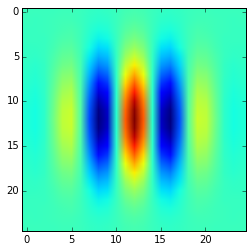

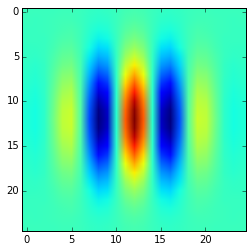

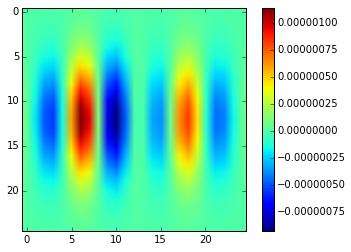

In [587]:
rf_data = scipy.io.loadmat('neuronRF.mat')
new_rf = rf_data['neuronRF']

plt.figure()
plt.imshow(new_rf)

plt.figure()
plt.imshow(sample.RF)

plt.figure()
plt.imshow(sample.RF - new_rf)
plt.colorbar()

Elapsed time to produce layer: 16 seconds


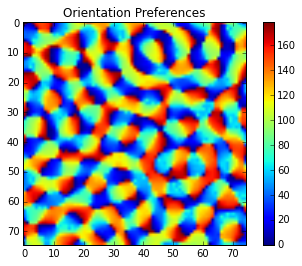

In [588]:
# load OP map from Bryan's extracted Kaschube map
data = scipy.io.loadmat('orientation-map.mat')
OP_map = np.floor(data['map'])
plt.imshow(OP_map)
plt.colorbar()
plt.title('Orientation Preferences')

start_time = time.time()
RF_layer = rf_layer(OP_map, N_pairs=75, field_size=75)
print "Elapsed time to produce layer: %d seconds" % (time.time()-start_time)

Sample orientation preference:  0.0


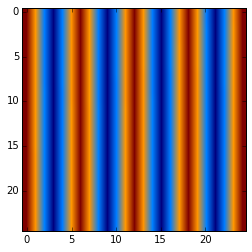

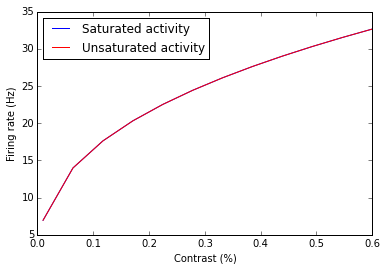

In [583]:
# sample = RF_layer.get_unit(55,28)
# sample = RF_layer.get_unit(12,2)
sample = RF_layer.get_unit(9,2)
# sample = RF_layer.get_unit(11,0)

print "Sample orientation preference: ", sample.ori_pref_deg

con_rng = np.linspace(0.01, 0.6, 12)
con_bank = np.zeros((len(con_rng), 25, 25))
grating = generate_static_grating(2*np.pi - sample.ori_pref_deg*np.pi/180, 1, 4, 25, norm=True)
plt.figure()
plt.imshow(grating)

for i in range(len(con_rng)):
    con_bank[i,:,:] = con_rng[i]*grating

con_rsp = np.zeros(len(con_rng))
unsat_rsp = np.zeros(len(con_rng))


for i in range(len(con_rsp)):
    con_rsp[i] = sample.get_unit_response_rate(con_bank[i,:,:], saturation=True)
    unsat_rsp[i] = sample.get_unit_response_rate(con_bank[i,:,:], saturation=False)
    
plt.figure()
plt.plot(con_rng, con_rsp, 'b', label='Saturated activity')
plt.plot(con_rng, unsat_rsp, 'r', label='Unsaturated activity')
plt.xlabel('Contrast (%)')
plt.ylabel('Firing rate (Hz)')
plt.legend(loc='best')

RF max:  0.00715656747601
RF min:  -0.00517954299093
RF mean:  -5.52967694736e-07


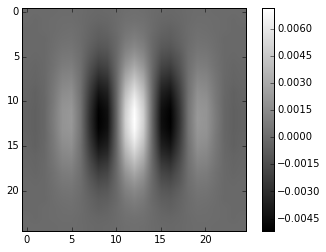

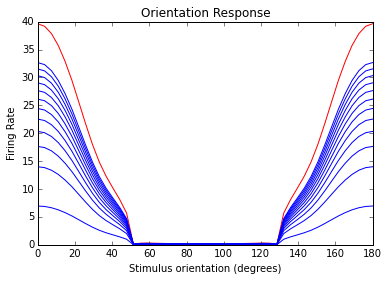

In [584]:
ori_rng = np.linspace(0, np.pi, 50)
ori_bank = generate_grating_bank(ori_rng, 1, 4, 25, norm=True)

ori_con_rsp = np.zeros((len(ori_rng), len(con_rng)+1))

sample.show_RF()

# plt.figure()
# plt.imshow(sample.quad_RF-sample.RF, cmap='gray')
# plt.colorbar()

print "RF max: ", np.max(sample.RF)
print "RF min: ", np.min(sample.RF)
print "RF mean: ", np.mean(sample.RF)

# print "Q max: ", np.max(sample.quad_RF)
# print "Q min: ", np.min(sample.quad_RF)
# print "Q mean: ", np.mean(sample.quad_RF)

for i in range(len(ori_rng)):
    stim = ori_bank[i,:,:]
#     ori_con_rsp[i,-1] = sample.get_unit_response_rate(stim, saturation=True)
    ori_con_rsp[i,-1] = sample.get_QP_response_rate(stim, saturation=True)
    for j in range(len(con_rng)):
#         ori_con_rsp[i,j] = sample.get_unit_response_rate(con_rng[j]*stim, saturation=True)
        ori_con_rsp[i,j] = sample.get_QP_response_rate(con_rng[j]*stim, saturation=True)

plt.figure()
plt.plot(ori_rng*180/np.pi, ori_con_rsp[:,-1], 'r')
plt.title('Orientation Response')
plt.xlabel('Stimulus orientation (degrees)')
plt.ylabel('Firing Rate')
for i in range(len(con_rng)):
#     plt.figure()
    plt.plot(ori_rng*180/np.pi, ori_con_rsp[:,i], 'b')

90.0
Pref orientation resp:  39.9431950278
Orth orientation resp:  7.04027607565
Cross orientation resp:  30.855742559


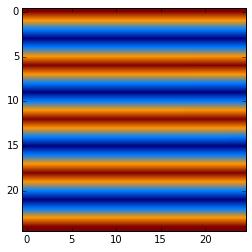

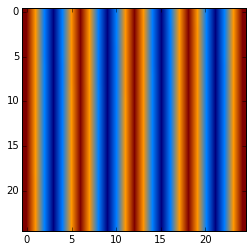

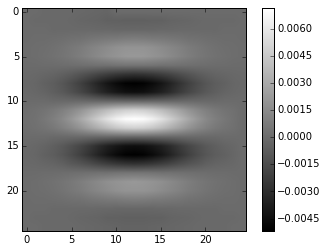

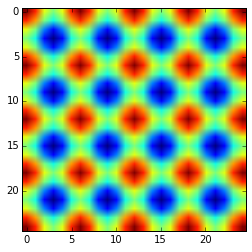

In [560]:
# Cross-orientation suppression experiment:
print sample.ori_pref_deg
contrast = 1
grating_pref = contrast*generate_static_grating(sample.ori_pref_deg*np.pi/180, 1, 4, 25, norm=True)
grating_orth = contrast*generate_static_grating((sample.ori_pref_deg+90)*np.pi/180, 1, 4, 25, norm=True)

plt.figure()
plt.imshow(grating_pref)

plt.figure()
plt.imshow(grating_orth)

sample.show_RF()

cross_ori_stim = (grating_pref + grating_orth)/2
plt.figure()
plt.imshow(cross_ori_stim)

print "Pref orientation resp: ", sample.get_unit_response_rate(grating_pref)
print "Orth orientation resp: ", sample.get_unit_response_rate(grating_orth)
print "Cross orientation resp: ", sample.get_unit_response_rate(cross_ori_stim)

Grating max val:  1.0
Grating min val:  0.0


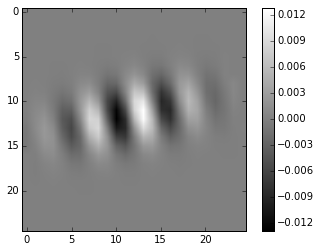

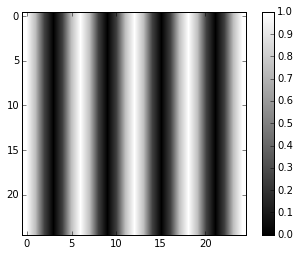

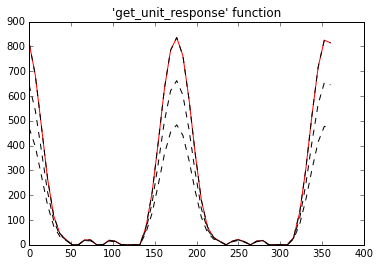

In [324]:
ori_range = np.linspace(0,2*np.pi,50)
# sample = rf_unit(1, orient_pref=30, pix_deg=25)
sample = RF_layer.get_unit(37,23)

sample.show_RF()

bank = generate_grating_bank(ori_range, 1, 4, 25, norm=True)
plt.figure()
plt.imshow(bank[0,:,:], cmap='gray')
plt.colorbar()
print 'Grating max val: ', np.max(bank[0,:,:])
print 'Grating min val: ', np.min(bank[0,:,:])

res = np.zeros_like(ori_range)
for i in range(len(ori_range)):
    stim = bank[i,:,:]
    res[i] = sample.get_unit_response_rate(stim, saturation=True)
plt.figure()
plt.plot(ori_range*180/np.pi, res, 'r')

ori_response = sample.get_unit_response_ori_range(ori_range)
plt.title('\'get_unit_response\' function')

contrast_range = np.linspace(0.1,1,5,True)
contrast_results = np.zeros((len(contrast_range), len(ori_range)))
for i in range(len(ori_range)):
    for j in range(2,len(contrast_range)):
        stim = contrast_range[j] * bank[i,:,:]
        contrast_results[j,i] = sample.get_unit_response_rate(stim, saturation=True)
        
for i in range(len(contrast_range)):
    plt.plot(ori_range*180/np.pi, contrast_results[i,:], 'k--')       

multiphase time:  0.130151987076
single phase time:  0.18914604187
Single phase non zero:  5546
Multi phase non zero:  5620
False
9.21215924015


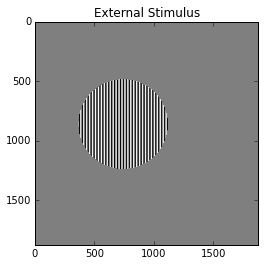

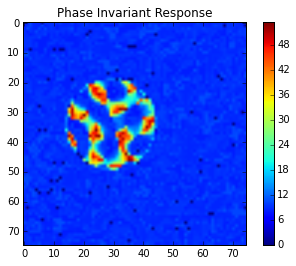

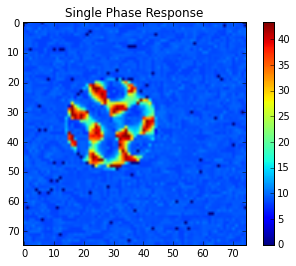

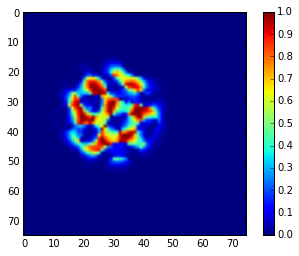

In [594]:
input_img = generate_static_grating(0, 75, 4*75, 25, phi=0, masked=True, mask_size=30, norm=True, mask_pos=[-8,-3])
plt.figure()
plt.imshow(input_img, cmap='gray')
plt.title("External Stimulus")
# plt.axes('off')

mp_time = time.time()
layer_response = RF_layer.get_layer_response_rates( input_img, phase_invariant=True )
print "multiphase time: ", time.time()-mp_time
plt.figure()
plt.imshow(layer_response)
plt.title("Phase Invariant Response")
plt.colorbar()
# plt.axes('off')

sp_time = time.time()
layer_response_sp = RF_layer.get_layer_response_rates( input_img, phase_invariant=False )
plt.figure()
plt.imshow(layer_response_sp)
plt.title("Single Phase Response")
plt.colorbar()
print "single phase time: ", time.time()-sp_time
print "Single phase non zero: ", len(np.where(layer_response_sp)[0])
print "Multi phase non zero: ",len(np.where(layer_response)[0])
print np.all(layer_response==layer_response_sp)

xi = 37-8
yi = 37-3
ssn_stim = ssn.generate_mono_stimulus(OP_map[yi,xi], 30./75*16, [xi*dx, yi*dx], OP_map, full_frame=False )
plt.figure()
plt.imshow(ssn_stim)
plt.colorbar()

35.2948456659
Ori pref:  160.0
35.2948456659
33.8365594199


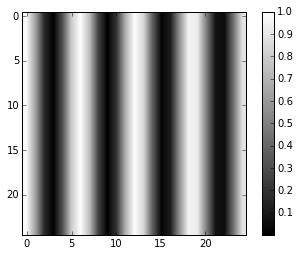

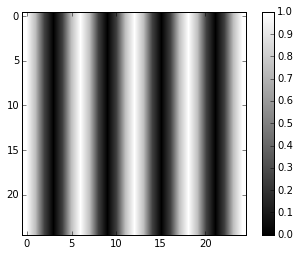

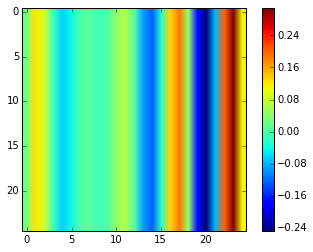

In [591]:
yi = 37
xi = 23
print layer_response_sp[yi,xi]
print "Ori pref: ", OP_map[yi,xi]
img_segment = input_img[yi*RF_layer.rf_size_pix:yi*RF_layer.rf_size_pix+RF_layer.rf_size_pix, xi*RF_layer.rf_size_pix:xi*RF_layer.rf_size_pix+RF_layer.rf_size_pix]
plt.figure()
plt.imshow(img_segment, cmap='gray')
plt.colorbar()

img = generate_static_grating(0, 1, 4, 25, phi=0, masked=False)
plt.figure()
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.figure()
plt.imshow(img-img_segment)
plt.colorbar()

print RF_layer.get_unit(yi,xi).get_unit_response_rate(img_segment, saturation=True)
print RF_layer.get_unit(yi,xi).get_unit_response_rate(img, saturation=True)

In [592]:
N_pairs = 75
field_size = 16.
dx = field_size/N_pairs

sig_FF = 32
sig_RF = dx

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5

# kappa_E = 0.18
# kappa_I = .85

# Original connection weights from Rubin et al., 2015:
# J_EE = 0.1
# J_IE = 0.38
# J_EI = 0.089
# J_II = 0.096

J_EE = 0.1
J_IE = 0.38
J_EI = 0.1
J_II = 0.086

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45
sig_OD = .25

[W_EE, W_IE, W_EI, W_II] = ssn.generate_connetion_weights( N_pairs, field_size, OP_map, kappa_E, kappa_I, J_EE, J_IE, J_EI, J_II, sig_EE, sig_IE, sig_EI, sig_II, sig_ori )

Mean no. of connections:
u_EE: 20	 u_IE: 41	 u_EI: 28	 u_II: 28
Omega_E:  -2242.872
Omega_I:  76656.06
System should show strong nonlinear behaviour!


In [59]:
# r_units = np.floor(N_pairs*np.random.rand(10,2))
contrast_range_ssn = np.linspace(3,50,10)
contrast_range_rf = np.linspace(0.05,1,10)
# ff_ssn_stim = np.zeros((len(r_units), N_pairs, N_pairs))
# ff_rf_stim  = np.zeros((len(r_units), len(contrast_range_ssn), N_pairs, N_pairs))

ssn_contrast_results = np.zeros((len(r_units), len(contrast_range_ssn), 2, N_pairs, N_pairs))
rf_contrast_results  = np.zeros((len(r_units), len(contrast_range_rf), 2, N_pairs, N_pairs))

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    ff_ssn_stim[i,:,:] = ssn.generate_mono_stimulus(OP_map[yi,xi], 1, [xi*dx, yi*dx], OP_map, full_frame=True )
    
    for j in range(len(contrast_range_rf)):
        xpos = dx*xi-37*dx
        ypos = dx*yi-37*dx
#         raw_img = generate_static_grating(OP_map[yi,xi]*np.pi/180, 16., 4*16, pix_deg=118, phi=0, masked=True, mask_size=stim_sizes[j], norm=True, mask_pos=[xpos, ypos])
#         ff_rf_stim[i,j,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=False)
        

In [61]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# SSN only:
start_time= time.time()
for i in range(6,len(r_units)):
    for j in range(len(contrast_range_ssn)):
        xi = r_units[i,0]
        yi = r_units[i,1]
        c = contrast_range_ssn[j]
        h = ff_ssn_stim[i,:,:]
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, c, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        ssn_contrast_results[i,j,0] = r_E[-1,:,:]
        ssn_contrast_results[i,j,1] = r_I[-1,:,:]
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 1331 seconds.


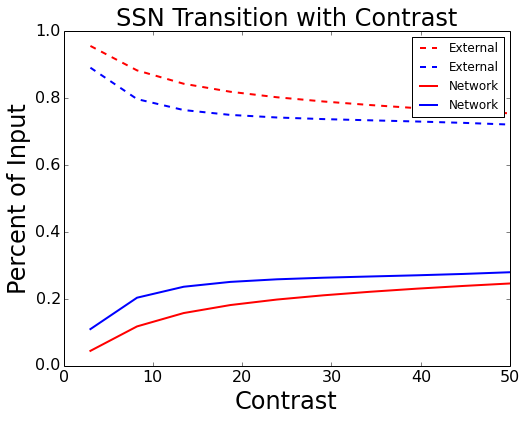

In [62]:
# plot reproductions of figure 6B: SSN only

ssn_E_external = np.zeros((len(r_units), len(contrast_range_ssn)))
ssn_I_external = np.copy(ssn_E_external)
ssn_E_network = np.copy(ssn_E_external)
ssn_I_network = np.copy(ssn_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_ssn)):
        ssn_E_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*W_EE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*W_EI[yi+xi*N_pairs,:,:])
        ssn_I_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*W_IE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*W_II[yi+xi*N_pairs,:,:])
        ssn_E_external[i,j] = np.sum(ff_ssn_stim[i,yi,xi]*contrast_range_ssn[j])
        
ssn_external_avg = np.mean(ssn_E_external,0)
ssn_E_net_avg = np.mean(ssn_E_network,0)
ssn_I_net_avg = np.mean(ssn_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_E_net_avg+ssn_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_I_net_avg+ssn_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_E_net_avg/(ssn_E_net_avg+ssn_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_ssn, ssn_I_net_avg/(ssn_I_net_avg+ssn_external_avg), 'b', linewidth=2, label="Network")
plt.title('SSN Transition with Contrast', fontsize=24)
plt.xlabel('Contrast', fontsize=24)
plt.ylabel('Percent of Input', fontsize=24)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(fontsize=12)
# plt.savefig('ssn_transition.eps', format='eps', dpi=1000)

0.409949979308
7360.31615078


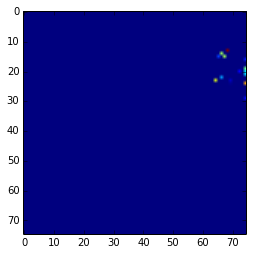

In [216]:
i = 5
xi = r_units[i,0]
yi = r_units[i,1]
plt.imshow(ssn_contrast_results[i,0,0]*W_EE[yi+xi*N_pairs,:,:])
print ssn_E_network[0,0]
print ssn_E_external[0,0]

In [180]:
pix_deg = 118
rf_layer_70 = rf_layer(OP_map, pix_deg=pix_deg)

print rf_layer_70.rf_size_pix

ori_range = np.linspace(0,np.pi,30)
ori_img_bank = np.zeros((len(ori_range), N_pairs, N_pairs))

i=2
xi = int(r_units[i,0])
yi = int(r_units[i,1])
xpos = dx*xi-37*dx
ypos = dx*yi-37*dx

for i in range(len(ori_range)):
    raw_img = generate_static_grating(ori_range[i], 16., 16*4, pix_deg, phi=0, masked=True, mask_size=3, norm=True, mask_pos=[xpos, ypos])
    ori_img_bank[i,:,:] = rf_layer_70.get_layer_response_rates(raw_img, phase_invariant=True)
    

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(ori_range*180/np.pi, ori_img_bank[:,yi,xi])

plt.figure()
plt.imshow(ori_img_bank[0,:,:])

In [113]:
ori_results = np.zeros((len(ori_range),2))
for i in range(len(ori_range)):
    rf_input = ori_img_bank[i,:,:]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, 1, rf_input, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    ori_results[i,0] = r_E[-1,yi,xi]
    ori_results[i,1] = r_I[-1,yi,xi]    

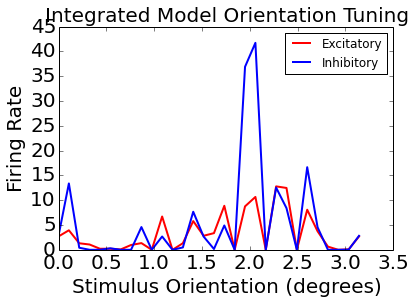

In [116]:
plt.figure()
font_size = 20
plt.title("Integrated Model Orientation Tuning", fontsize=font_size)
plt.plot(ori_range, ori_results[:,0], 'r', linewidth=2, label='Excitatory')
plt.plot(ori_range, ori_results[:,1], 'b', linewidth=2, label='Inhibitory')
plt.xlabel("Stimulus Orientation (degrees)", fontsize=font_size)
plt.ylabel("Firing Rate", fontsize=font_size)
plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)
plt.legend(fontsize=12)
# plt.savefig('integrated_o_tuning.eps', format='eps', dpi=1000)

In [51]:
# Contrast Saturation Sample

contrast_range_rf = np.linspace(0.05,1,10)
contrast_img_bank = np.zeros((len(contrast_range_rf), N_pairs, N_pairs))

xi = 37
yi = 37
pix_deg = 25
print (xi,yi)
rf_dx = 25
xpos = rf_dx*xi-37*rf_dx
ypos = rf_dx*yi-37*rf_dx

for i in range(len(contrast_range_rf)):
    raw_img = contrast_range_rf[i]*generate_static_grating(0, 75., 75*4, pix_deg, phi=0, masked=True, mask_size=3, norm=True, mask_pos=[xpos, ypos])
    contrast_img_bank[i,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=False)

(37, 37)


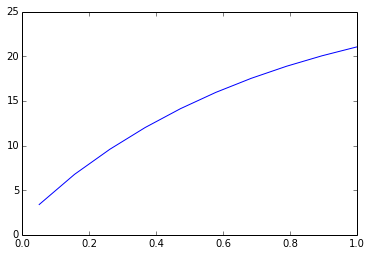

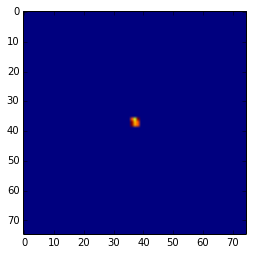

In [52]:
plt.figure()
plt.plot(contrast_range_rf, contrast_img_bank[:,yi,xi])

plt.figure()
plt.imshow(contrast_img_bank[9,:,:])

In [16]:
dt = 0.005
timesteps = 100

contrast_results = np.zeros((len(contrast_range_rf),2))
for i in range(len(contrast_range_rf)):
    rf_input = contrast_img_bank[i,:,:]
    [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, 1, rf_input, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
    contrast_results[i,0] = r_E[-1,yi,xi]
    contrast_results[i,1] = r_I[-1,yi,xi]    

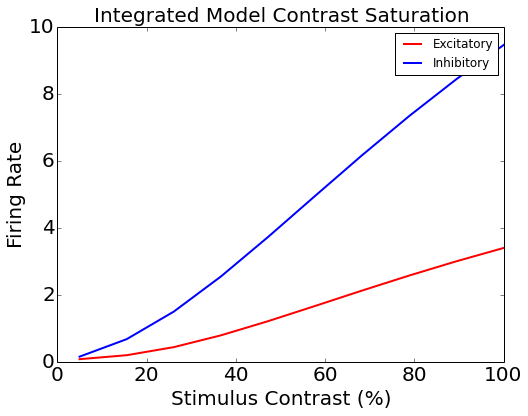

In [17]:
plt.figure(figsize=(8, 6))
font_size = 20
plt.title("Integrated Model Contrast Saturation", fontsize=font_size)
plt.plot(contrast_range_rf*100, contrast_results[:,0], 'r', linewidth=2, label='Excitatory')
plt.plot(contrast_range_rf*100, contrast_results[:,1], 'b', linewidth=2, label='Inhibitory')
plt.xlabel("Stimulus Contrast (%)", fontsize=font_size)
plt.ylabel("Firing Rate", fontsize=font_size)
plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)
plt.legend(fontsize=12)
# plt.savefig('integrated_contrast_saturation.eps', format='eps', dpi=1000)

In [55]:
r_units = np.floor( N_pairs*np.random.rand(10,2) )

contrast_range_ssn = np.linspace(3,50,10)
contrast_range_rf = np.linspace(0.05,1,10)
ff_ssn_stim = np.zeros((len(r_units), N_pairs, N_pairs))
ff_rf_stim  = np.zeros((len(r_units), len(contrast_range_ssn), N_pairs, N_pairs))
ff_rf_stim_pi = np.copy(ff_rf_stim)

ssn_contrast_results = np.zeros((len(r_units), len(contrast_range_ssn), 2, N_pairs, N_pairs))
rf_contrast_results  = np.zeros((len(r_units), len(contrast_range_rf), 2, timesteps, N_pairs, N_pairs))

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
#     ff_ssn_stim[i,:,:] = ssn.generate_mono_stimulus(OP_map[yi,xi], 1, [xi*dx, yi*dx], OP_map, full_frame=True )
    
    for j in range(len(contrast_range_rf)):
        raw_img = contrast_range_rf[j]*generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=25, phi=0, masked=False, mask_size=150, norm=True, mask_pos=[0,0])
        ff_rf_stim[i,j,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=False)*3.1896
        # ff_rf_stim_pi[i,j,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=True)        

Unit:  [ 72.  22.]
Preference:  2.03773584906


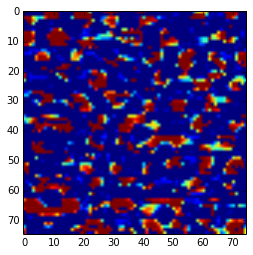

In [56]:
i = 4
print "Unit: ", r_units[i]
print "Preference: ", OP_map[r_units[i,1], r_units[i,0]]
plt.imshow(ff_rf_stim[i,9])

In [57]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# RF only:
start_time= time.time()
for i in range(len(r_units)):
    for j in range(len(contrast_range_rf)):
        xi = r_units[i,0]
        yi = r_units[i,1]
        h = ff_rf_stim[i,j,:,:]
        
        [r_E, r_I, I_E, I_I] = ssn.run_simulation(dt, timesteps, 1, h, k, n_E, n_I, tau_E, tau_I, W_EE, W_EI, W_IE, W_II)
        rf_contrast_results[i,j,0] = r_E
        rf_contrast_results[i,j,1] = r_I
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

ssn.py:413: RuntimeWarning: overflow encountered in power
  rSS_E = np.multiply(k, np.power(np.fmax(0,I_E[t,:,:]), n_E))
ssn.py:414: RuntimeWarning: overflow encountered in power
  rSS_I = np.multiply(k, np.power(np.fmax(0,I_I[t,:,:]), n_I))
ssn.py:422: RuntimeWarning: overflow encountered in divide
  r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))
ssn.py:409: RuntimeWarning: invalid value encountered in multiply
  I_E[t,:,:] = c*h + np.sum( np.sum( W_EE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_EI * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T
ssn.py:410: RuntimeWarning: invalid value encountered in multiply
  I_I[t,:,:] = c*h + np.sum( np.sum( W_IE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_II * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T
ssn.py:421: RuntimeWarning: invalid value encountered in add
  r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))


Elapsed time: 3502 seconds.


ssn.py:422: RuntimeWarning: invalid value encountered in add
  r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))


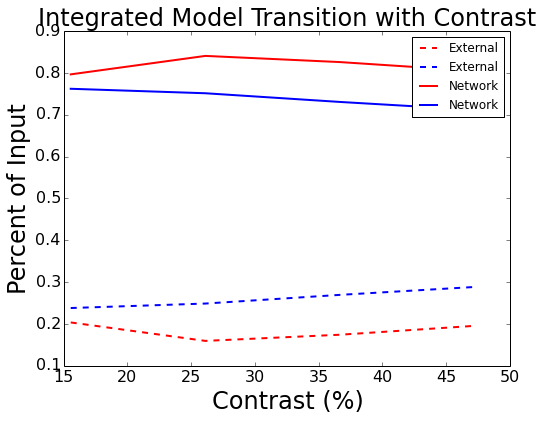

In [58]:
# plot reproductions of figure 6B: RF only

rf_E_external = np.zeros((len(r_units), len(contrast_range_rf)))
rf_I_external = np.copy(rf_E_external)
rf_E_network = np.copy(rf_E_external)
rf_I_network = np.copy(rf_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_rf)):
        rf_E_network[i,j] = np.sum(rf_contrast_results[i,j,0,-1]*W_EE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1,-1]*W_EI[yi+xi*N_pairs,:,:])
        rf_I_network[i,j] = np.sum(rf_contrast_results[i,j,0,-1]*W_IE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1,-1]*W_II[yi+xi*N_pairs,:,:])
        rf_E_external[i,j] = np.sum(ff_rf_stim[i,j,yi,xi])
        
rf_external_avg = np.mean(rf_E_external,0)
rf_E_net_avg = np.mean(rf_E_network,0)
rf_I_net_avg = np.mean(rf_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_rf*100, rf_external_avg/(rf_E_net_avg+rf_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, rf_external_avg/(rf_I_net_avg+rf_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, rf_E_net_avg/(rf_E_net_avg+rf_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_rf*100, rf_I_net_avg/(rf_I_net_avg+rf_external_avg), 'b', linewidth=2, label="Network")

plt.title('Integrated Model Transition with Contrast',fontsize=24)
plt.xlabel('Contrast (%)', fontsize=24)
plt.ylabel('Percent of Input', fontsize=24)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(fontsize=12)
#plt.savefig('integrated_transition.eps', format='eps', dpi=1000)

In [ ]:
j = 0
plt.figure()
for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    plt.plot(np.linspace(0,timesteps*dt, timesteps), rf_contrast_results[i,j,0,:,yi,xi], 'r')
    
plt.figure()
for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    plt.plot(np.linspace(0,timesteps*dt, timesteps), rf_contrast_results[i,j,1,:,yi,xi], 'b')    

In [35]:
for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    print rf_contrast_results[i,-1,0,-1,yi,xi]

print '----------------------'

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    print rf_contrast_results[i,-1,1,-1,yi,xi]    

6.1560992826e-12
1.06739064069e-09
2.28810333052e-13
0.0
2.41558098209e-13
2.13462130764e+92
1.2045300718e-10
8.10944592383e+267
9.33691169281e-11
3.14585038016e-13
----------------------
1.07930028723e-25
2.51430610843e+167
1.31117510416e+151
6.34337730083e-16
1.18283253984e-23
9.72361533134e+267
nan
0.0
6.4746664595e-16
5.18567986899e-23


39158.6829754
124901.640003
3.18962821301


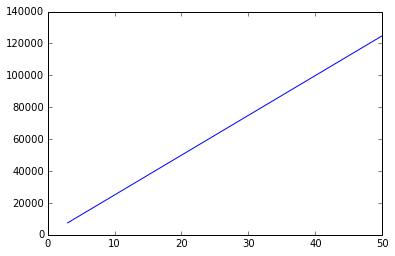

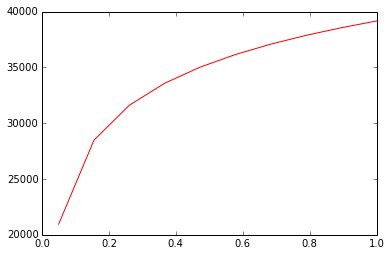

In [50]:
# Plot the external inputs h(x) for both SSN and RF models:
ssn_stim_sum = np.zeros(len(contrast_range_ssn))

for i in range(len(contrast_range_ssn)):
    ssn_stim_sum[i] = np.mean(np.sum(np.sum(contrast_range_ssn[i]*ff_ssn_stim,1),1))

rf_stim_sum = np.mean( np.sum(np.sum(ff_rf_stim,2),2),0 )
                              
plt.figure()
plt.plot(contrast_range_ssn, ssn_stim_sum, 'b')

plt.figure()
plt.plot(contrast_range_rf, rf_stim_sum, 'r')

print np.max(rf_stim_sum)
print np.max(ssn_stim_sum)
print np.max(ssn_stim_sum)/np.max(rf_stim_sum)

(10, 10)


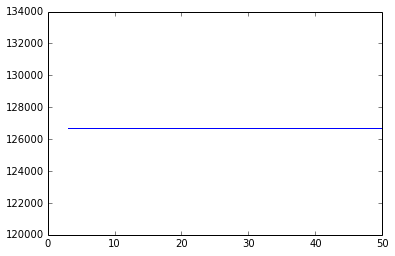

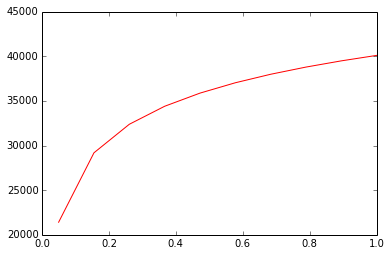

In [39]:
# Plot the external inputs h(x) for both SSN and RF models:
ssn_stim_sum = np.zeros(len(contrast_range_ssn))

for i in range(len(contrast_range_ssn)):
    ssn_stim_sum[i] = np.sum(np.sum(contrast_range_ssn[j]*ff_ssn_stim, 1),1)[0]

rf_stim_sum = np.sum(np.sum(ff_rf_stim,2),2)[0]

print np.sum(np.sum(ff_rf_stim,2),2).shape
                              
plt.figure()
plt.plot(contrast_range_ssn, ssn_stim_sum, 'b')

plt.figure()
plt.plot(contrast_range_rf, rf_stim_sum, 'r')

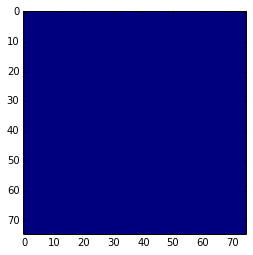

In [33]:
plt.imshow(ff_rf_stim[0,9,])

In [40]:
print contrast_range_ssn

[  3.           8.22222222  13.44444444  18.66666667  23.88888889
  29.11111111  34.33333333  39.55555556  44.77777778  50.        ]


In [47]:
print np.mean(np.sum(np.sum(contrast_range_ssn[2]*ff_ssn_stim,1),1))

33584.6632008
